# Creating an image analysis algorithm with Python

In this notebook, we create an image analysis algorithm using the Python libraries `numpy`, `scipy` and `scikit-image`. We also use the image simulation code `abTEM` to generate example data. The example algorithm finds single vacancies in a noisy simulated graphene image using Bragg filtering and blob detection.

### Contents:

1. [Simulating HRTEM test data](#simulation)
    1. Create defect graphene sheet
    2. Simulate HRTEM image
    3. Postprocess simulated image
2. [Finding defects with Bragg filtering and blob detection](#finding_defects)
    1. Apply windowed Fourier transform
    2. Find diffraction spots
    3. Create Bragg mask
    4. Apply Bragg filter
    5. Blob detection

### Authors:
* 02/04/2022 Jacob Madsen - For HyperSpy workshop at ePSIC 2022

In [75]:
%matplotlib notebook

import abtem as ab
from abtem.structures import cut_rectangle
from abtem.noise import poisson_noise
import ase

import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage

## Simulating test data <a id='simulation'></a>
When developing algorithms for image analysis it is sometimes useful to use simulated data. Simulations can let you custom-taylor the data to some scenario, and you are able to tune parameters such as noise level to perfect the algorithm. Additionally, since the true sample structure is known in a simulation it is easy to quantify errors.

The next cells assumes that you have seen the "atomic_models_with_ase.ipynb" and "image_simulation_with_abtem.ipynb" notebooks.

We import a graphene structure, rotate the cell, then use the `cut_rectangle` function to create an axis-aligned and orthogonal structure. Note that the structure is _not_ periodic, this will create an issue, that we have to solve later on. 

### Create a defect graphene sheet 

In [103]:
graphene = ase.io.read('hexagonal_graphene.cif')

graphene.rotate('z', 25, rotate_cell=True)

graphene = cut_rectangle(graphene, extent = (110, 110), origin = (0, 0))

We add point vacancies with a probability of 0.5 %. 

<IPython.core.display.Javascript object>


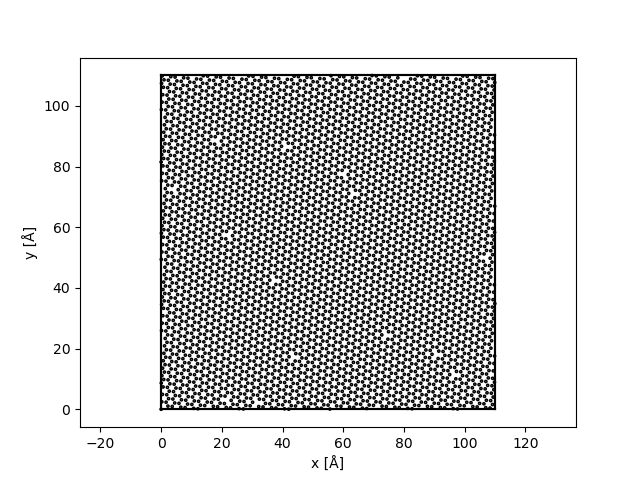

In [104]:
defect_graphene = graphene.copy()

del defect_graphene[np.where(np.random.rand(len(defect_graphene)) < .005)]

ab.show_atoms(defect_graphene);

### Simulate HRTEM image
We create a `PlaneWave` with an acceleration voltage of 80 keV and a real space sampling of 0.2 Å. Then the multislice algorithm is used to calculate the exit wave function. To use a potential with default parameters, it is not neccesary to create a `Potential` explicitly. 

In [105]:
wave = ab.PlaneWave(energy=80e3, sampling=.05)

exit_wave = wave.multislice(defect_graphene)

Potential:   0%|          | 0/12 [00:00<?, ?it/s]

Multislice:   0%|          | 0/12 [00:00<?, ?it/s]

We show the intensity of the complex exit wave function.

<IPython.core.display.Javascript object>


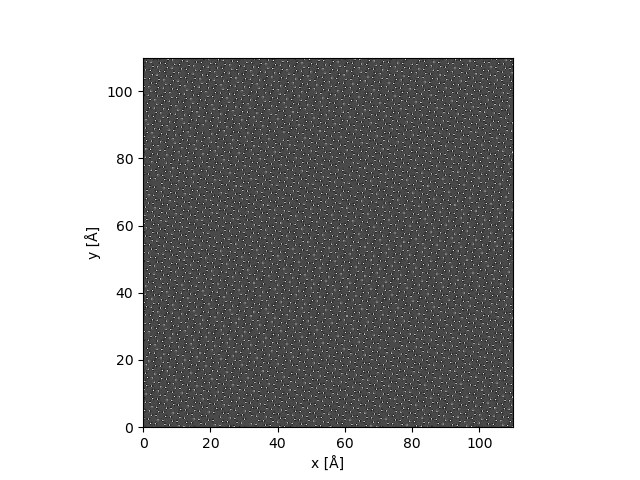

In [106]:
exit_wave.show();

To create an image we need apply the effects of the objective lens. If the microscope is well aligned then off-axis aberrations are small and the phase error is dominated by defocus and spherical aberration

$$
    \chi(k) \approx \frac{2\pi}{\lambda}\left( \frac{\lambda^2 k^2}{2} \Delta f + \frac{\lambda^4 k^4}{4} C_s \right) \quad ,
$$

where $\Delta f$ is the defocus and $C_s$ is the third order spherical aberration.

Here we set the spherical aberration to $80 \ \mu m$ ($80000 \mathrm{Å}$), and adjust the defocus to the [Scherzer defocus](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy#Scherzer_defocus).

In [107]:
Cs = -40e4 # Å

defocus = ab.transfer.scherzer_defocus(energy=wave.energy, Cs=Cs)

print(f'Scherzer defocus: {defocus:.2f} Å')

Scherzer defocus: -158.29 Å


<div class= "alert alert-info">

**Note: Defocus convention**

The defocus is by convention defined as negative `C10`. Applying a positive defocus is equivalent to free-space propagation in the direction from positive to negative $z$.
    
</div>

We adjust the `semiangle_cutoff` (or objective aperture) to match the first crossing of zero. This is not necessarily optimal, and may not match your experimental setup.

<IPython.core.display.Javascript object>


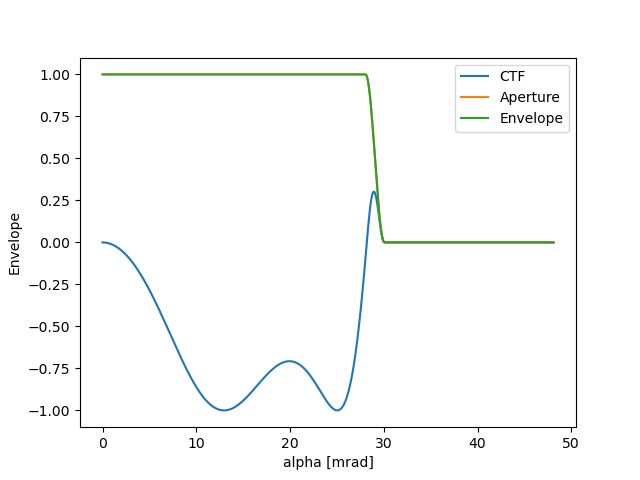

In [108]:
objective_aperture = 30 # mrad

ctf = ab.CTF(Cs=Cs, defocus=defocus, energy=wave.energy, semiangle_cutoff=objective_aperture)

plt.figure()
ctf.show();

We may also want to include partial temporal coherence by setting the focal spread of the CTF. By setting a focal spread an envelope will be applied to the CTF.

<IPython.core.display.Javascript object>


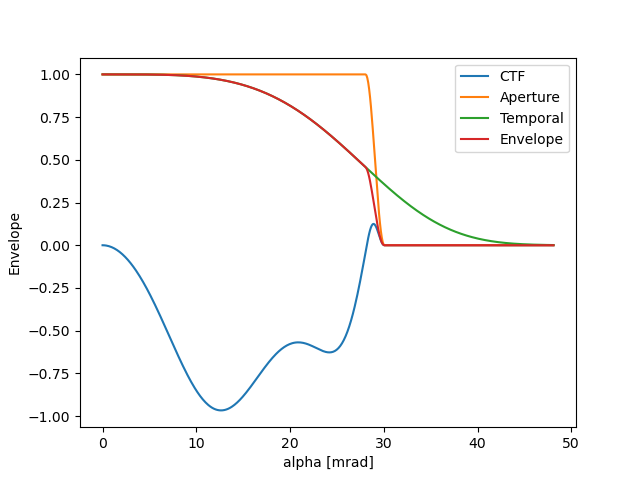

In [109]:
ctf.focal_spread = 30 # Å

plt.figure()
ax = ctf.show()

<div class= "alert alert-info">
    
**Note: The quasi-coherent approximation**
    
Partial spatial coherence is in the contrast transfer function using the quasi-coherent approximation, where high spatial frequencies are damped using an envelope function. While this is efficient, the approximation may not always be appropriate.

</div>

We apply the contrast transfer function and calculate the image intensity.

<IPython.core.display.Javascript object>


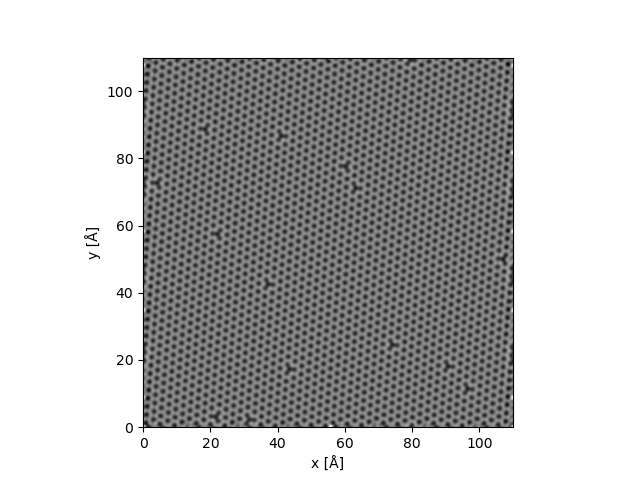

In [110]:
intensity = exit_wave.apply_ctf(ctf).intensity()
intensity.show();

### Postprocess simulated image

Notice the image artifacts along the borders, this is because the input atomic model is non-periodic. A quick fix is to simply crop the boundary region from the image, here we remove a margin of $5 \ \mathrm{Å}$ at each side of the image. 

<IPython.core.display.Javascript object>


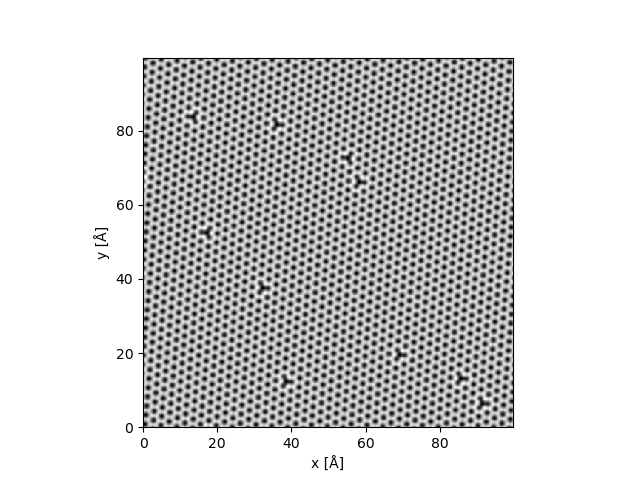

In [111]:
cropped = intensity.interpolate(.2).crop(margin = (5, 5))
cropped.show();

We can add a realistic level of Poisson noise (shot noise) by setting an electron dose of $10000 \ \mathrm{e}^- / \mathrm{Å}^2$

<IPython.core.display.Javascript object>


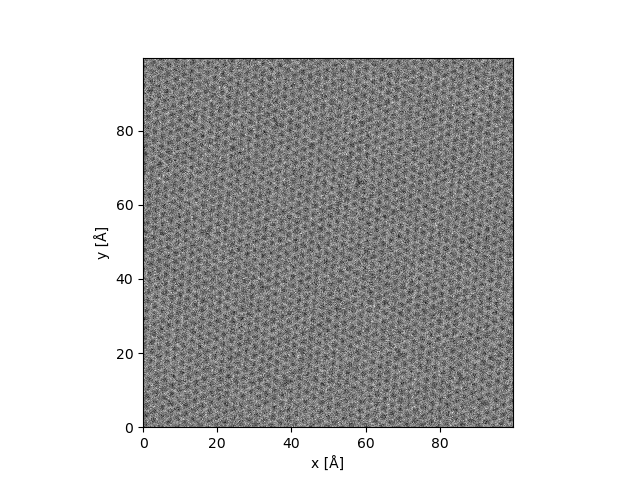

In [112]:
dose = 1e4 # e- / Å^2

noisy = poisson_noise(cropped, dose=dose)
noisy.show();

From here we will no longer use `abTEM`, hence we retrieve the `abTEM` "measurement" as a `numpy` array.

<IPython.core.display.Javascript object>


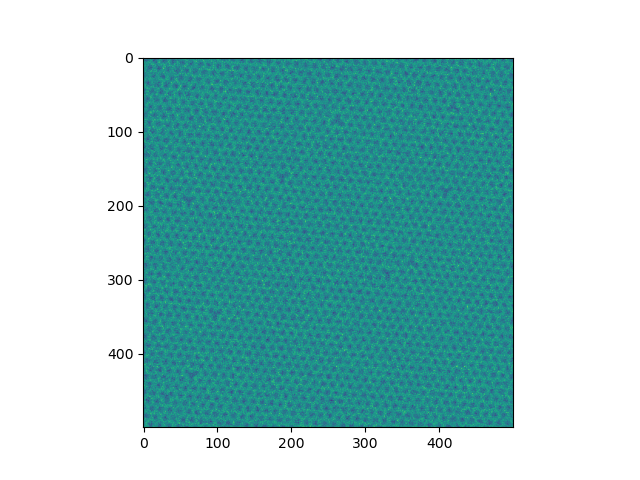

In [113]:
image = noisy.array

plt.figure()
plt.imshow(image);

<div class= "alert alert-info">

**Note: Axes convention**

The axes convention for arrays representing a wave functions assigns the first axis to the $x$-axis and the second axis to the $y$-axis, and a larger array index implies a larger real-space coordinate. This is different from the convention often used for images. The correct way of displaying an array with `matplotplib` is given below.
    
```
import matplotlib.pyplot as plt
image = np.abs(waves.array[0]) ** 2
plt.imshow(image.T, extent=[0, waves.extent[0], 0, waves.extent[1]], origin='lower')
```     
  
</div>

## Finding defects with Bragg filtering and blob detection <a id='finding_defects'></a>

In the following cells, we create an algorithm for finding defects in graphene using Bragg filtering and blob detection.

### Apply windowed Fourier transform

We apply a Fourier transform to the simulated image using the `np.fft` module. 


In [114]:
f = np.fft.fftshift(np.fft.fft2(image))

The Fourier transform is complex-valued in general, hence it is often more convenient to display the absolute value. We also take the logarithm as the zero'th order spot would dominate the signal otherwise. We add 1 to the absolute value to avoid the possibility of taking the logarithm of zero.

<IPython.core.display.Javascript object>


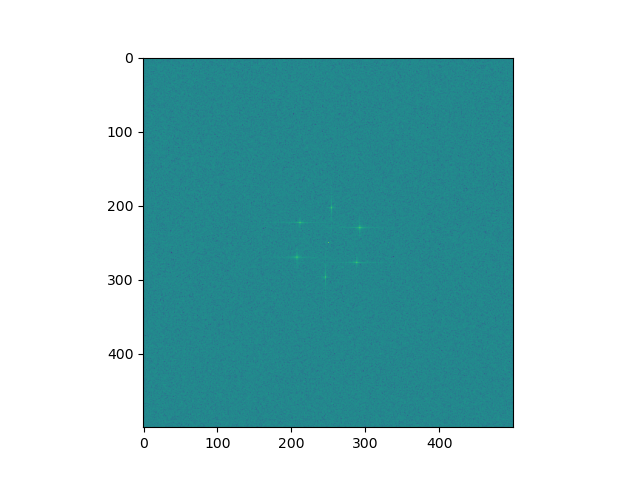

In [115]:
def fft_display_values(f):
    return np.log(1 + np.abs(f))

plt.figure()
plt.imshow(fft_display_values(f));

The streaks around the diffraction in the FFT comes from the discontinuity at the boundary of the image and can be removed by applying a [window function](https://en.wikipedia.org/wiki/Window_function) to the original signal before computating of the FFT. 

The `scipy.signal.windows` module has a multiple of available window functions, see [docs](https://docs.scipy.org/doc/scipy/reference/signal.windows.html). Here we choose a Hanning window, this is also default when setting `apodization = True` using the `.fft` method of a `hyperspy` signal.

Since the created windows are 1d, we calculate the [outer product](https://en.wikipedia.org/wiki/Outer_product) to obtain a 2d window.

<IPython.core.display.Javascript object>


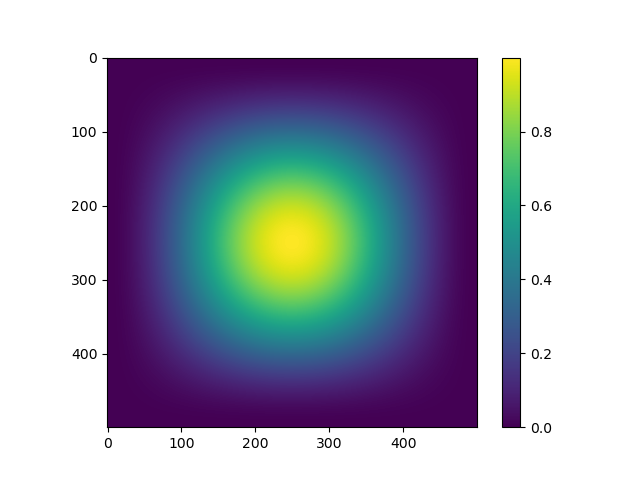

In [116]:
import scipy.signal

hanning_x = scipy.signal.windows.hann(image.shape[0])
hanning_y = scipy.signal.windows.hann(image.shape[1])

hanning_window = np.outer(hanning_x, hanning_y)

plt.figure()
plt.imshow(hanning_window)
plt.colorbar();

To use the window function we just multiply the image with the window function array.

<IPython.core.display.Javascript object>


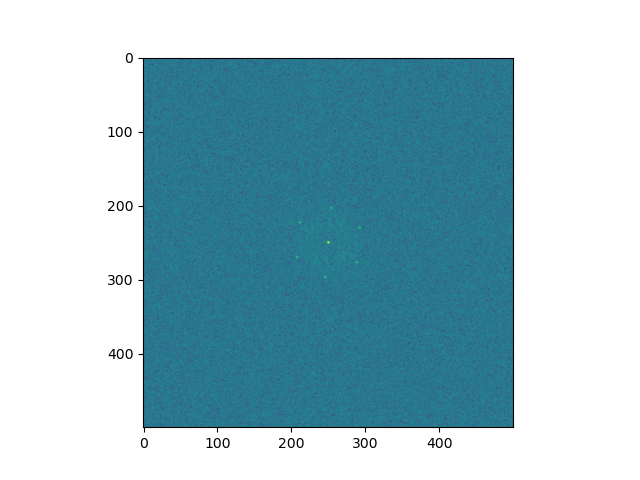

In [90]:
f = np.fft.fftshift(np.fft.fft2(image * hanning_window))

plt.figure()
plt.imshow(fft_display_values(f));

### Find diffraction spots

The `skimage.feature.peak_local_max` function returns the coordinates of local peaks (maxima) in an image. A minimum distance between the detected peaks is given to avoid detecting the same peak multiple times.

In [24]:
coordinates = skimage.feature.peak_local_max(np.abs(f), min_distance=10)

Plotting the detected peaks, we see that, in addition to the diffraction spots, a lot of unwanted peaks in the random noise was found.

<IPython.core.display.Javascript object>


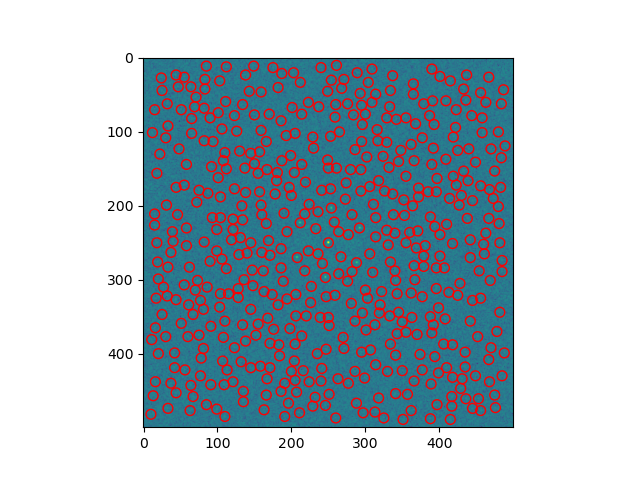

In [25]:
plt.figure()
plt.imshow(fft_display_values(f))
plt.scatter(coordinates[:,1], coordinates[:,0], s = 50, facecolors = 'none', edgecolors = 'r');

We expect the most intense peak to be the zero'th order spot, the next six peaks will be the first order spots. Hence, we may select these spots by slicing the array of coordinates from index 1 through 7. 

<IPython.core.display.Javascript object>


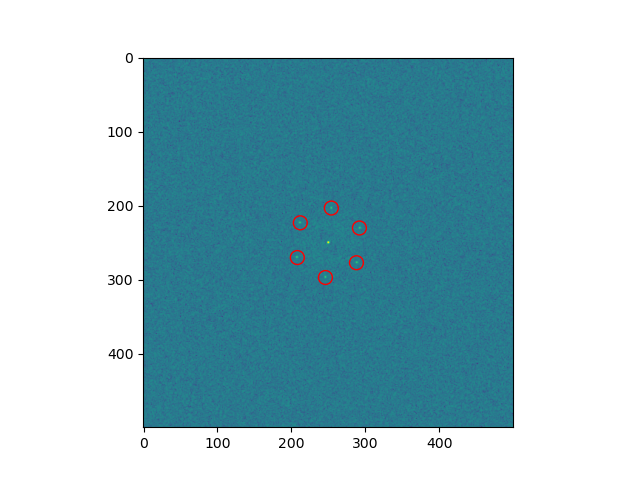

In [26]:
selected_coordinates = coordinates[1:7]

plt.figure()
plt.imshow(fft_display_values(f))
plt.scatter(selected_coordinates[:,1], selected_coordinates[:,0], s = 100, facecolors = 'none', edgecolors = 'r');

As a final note, it was quite easy to find the diffraction spot in this example. When you have more complex examples, you are likely to be happy about using [`pyxem`](https://github.com/pyxem/pyxem).

### Create Bragg mask

The Bragg mask will be an array with zeros everywhere except for the regions around the first order diffraction spots. 

We start by creating an array of zeros and set the pixels at the diffraction spots to 1, i.e. the array represents a set of delta-functions placed at the positions of the Bragg spots.

<IPython.core.display.Javascript object>


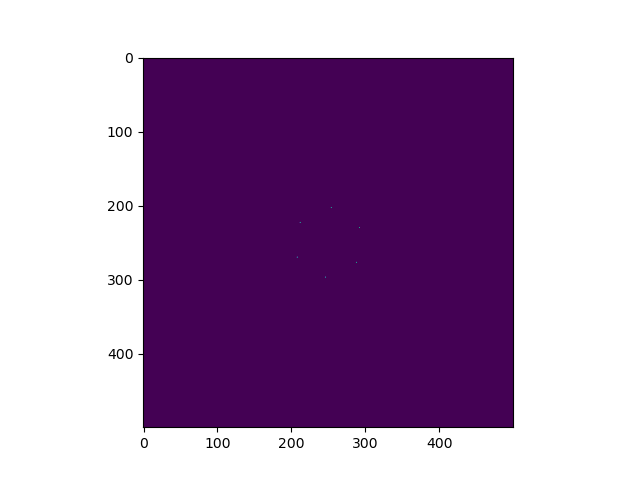

In [27]:
delta_mask = np.zeros_like(f, dtype=float)

delta_mask[selected_coordinates[:,0], selected_coordinates[:,1]] = 1

plt.figure()
plt.imshow(delta_mask);

`skimage.morphology` has various structuring elements such as disks and rectangles.

<IPython.core.display.Javascript object>


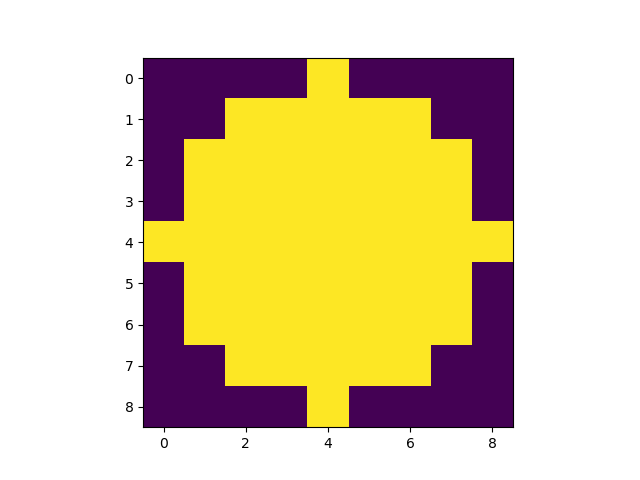

In [28]:
disk = skimage.morphology.disk(4).astype(float)

plt.figure()
plt.imshow(disk);

To finalize the Bragg mask, we convolve the disk with the array with the delta-functions.

<IPython.core.display.Javascript object>


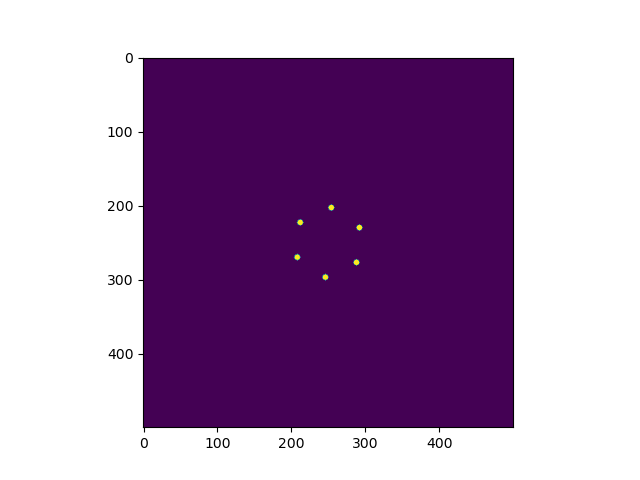

In [29]:
mask = scipy.signal.fftconvolve(delta_mask, disk, mode='same')

plt.figure()
plt.imshow(mask);

Note that the Bragg mask could be improved slightly making the edges of the disks smoother.

### Apply Bragg filter 

We apply the Bragg mask to the Fourier transformed image. Here, we do not use windowing and we make sure to inverse shift the mask.

In [30]:
filtered = np.fft.ifft2(np.fft.fft2(image) * np.fft.ifftshift(mask))

The result is complex-valued, to get the Bragg filtered image we select the real part.

<IPython.core.display.Javascript object>


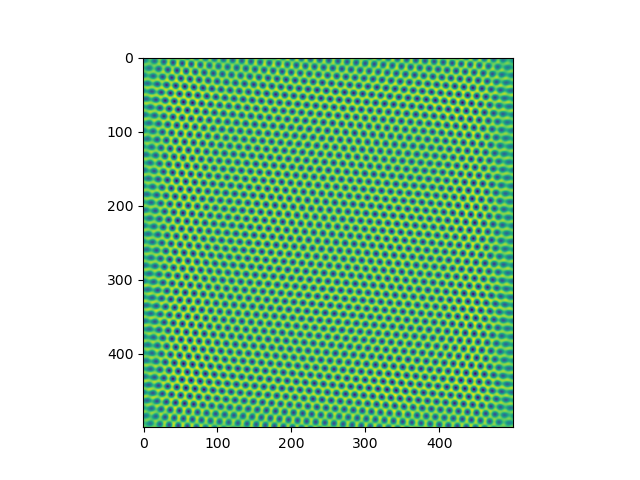

In [31]:
plt.figure()
plt.imshow(filtered.real);

The Bragg filtered image shows a perfect graphene lattice. The trick to using Bragg filtering to finding the defects is to subtract the original image from the periodic Bragg filtered image.   

<IPython.core.display.Javascript object>


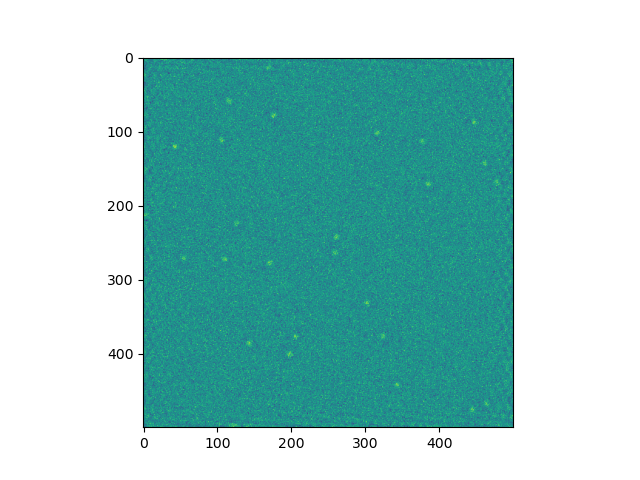

In [37]:
non_periodic = filtered - image

plt.figure()
plt.imshow(non_periodic.real);

### Blob detection

The image above should show the defects as bright "blobs" on a noisy background. Blob detection has some actual theory behind it, see the wiki page. We will use the `scikit-image` implementation of the "Laplacian-of-Gaussian" (LOG) algorithm.

Before using the algorithm we normalize the "blob image" to have values between zero and one.

In [72]:
blob_image = non_periodic.real

blob_image = (blob_image - blob_image.min()) / blob_image.ptp()

We use the `scikit-image` implementation of the LOG algorithm to find the blobs, the parameters are explaing in the [docs](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.blob_log). Finding the right parameters 

In [73]:
blobs_log = skimage.feature.blob_log(blob_image, 
                                     min_sigma = 4,
                                     max_sigma = 8, 
                                     num_sigma = 20, 
                                     threshold = .08,
                                     exclude_border = 10)

Selecting the optimal parameters for the blob detection algorithm is not trivial. You might even want to use some machine learning methods to find the best parameters. 

<IPython.core.display.Javascript object>


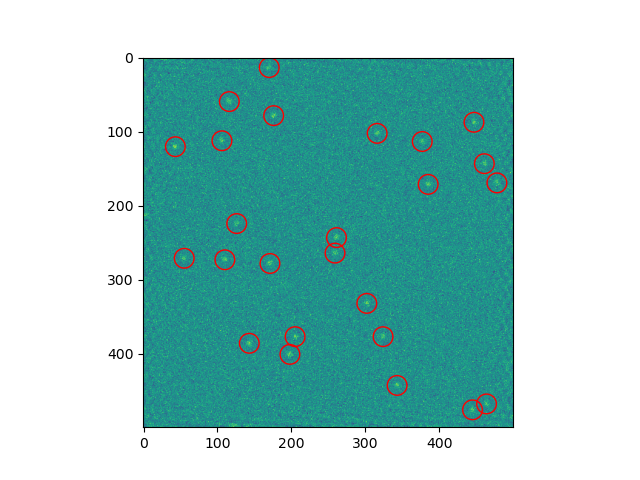

In [74]:
plt.figure()
plt.imshow(non_periodic.real);
plt.scatter(blobs_log[:,1], blobs_log[:,0], s = 200, facecolors = 'none', edgecolors = 'r');

### Next steps

The next step from here would be to quantify the errors in terms of [precission and recall](https://en.wikipedia.org/wiki/Precision_and_recall). Having an error quationtification is important to improve the algorithm. We need to make sure that that the algorithm is robust to noise and realistic changes to imaging parameters.

In this example, we used simulated data to develop the algorithm. The step from simulated data to real data is not always smooth. Hence testing the algorithm on real data is also important.

Jupyter notebooks are great for prototyping an analysis algorithm. However, once you have a working algorithm you should create proper python functions, preferably with documentation! 
